**Souptik Dolui (25167045), Suraj Santra (25167036), Kamal Kiran Mahanna (25167047), Riddhi Dey (25167024), Debabrata Ghosh (25167016)**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_squared_error, mean_absolute_error, r2_score)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

In [2]:
# 1. Load dataset
url = "https://raw.githubusercontent.com/bapujik/dataSets/refs/heads/main/Bengaluru_House_Data.csv"
df = pd.read_csv(url)
print("Loaded dataset shape:", df.shape)
print(df.columns.tolist())
display(df.head())

Loaded dataset shape: (13320, 9)
['area_type', 'availability', 'location', 'size', 'society', 'total_sqft', 'bath', 'balcony', 'price']


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
# 2. Quick EDA & summary
print("\n Info")
df.info()
print("\n Numeric summary")
display(df.describe().T)
print("\n Missing values per column")
print(df.isnull().sum())

# Save a copy of original for comparisons later
df_original = df.copy()


 Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB

 Numeric summary


,count,mean,std,min,25%,50%,75%,max
bath,13247.0,2.692610,1.341458,1.0,2.0,2.0,3.0,40.0
balcony,12711.0,1.584376,0.817263,0.0,1.0,2.0,2.0,3.0
price,13320.0,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0



 Missing values per column
area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64


In [4]:
# 3. Basic cleaning & feature engineering

def extract_bhk(x):
    try:
        return int(str(x).split()[0])
    except:
        return np.nan

if 'size' in df.columns:
    df['bhk'] = df['size'].apply(extract_bhk)
else:
    df['bhk'] = np.nan

def sqft_to_num(x):
    try:
        if isinstance(x, str):
            x = x.strip()

            if '-' in x:
                parts = x.split('-')
                nums = [float(p.strip()) for p in parts if p.strip()]
                return sum(nums)/len(nums)
            else:
                s = ''.join(ch for ch in x if (ch.isdigit() or ch=='.'))
                if s == '':
                    return np.nan
                return float(s)
        elif np.isfinite(x):
            return float(x)
        else:
            return np.nan
    except:
        return np.nan

if 'total_sqft' in df.columns:
    df['total_sqft_num'] = df['total_sqft'].apply(sqft_to_num)
else:
    df['total_sqft_num'] = np.nan

if 'price' not in df.columns and 'price (lakh)' in df.columns:
    df.rename(columns={'price (lakh)': 'price'}, inplace=True)

df = df.dropna(subset=['total_sqft_num','price','bhk'], how='any').copy()
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.dropna(subset=['price'], inplace=True)

df['price_per_sqft'] = (df['price']*100000) / df['total_sqft_num']  # convert lakh->rupees if price in lakhs

print("\nAfter basic feature engineering shape:", df.shape)
display(df[['total_sqft','total_sqft_num','size','bhk','price','price_per_sqft']].head())


After basic feature engineering shape: (13292, 12)


,total_sqft,total_sqft_num,size,bhk,price,price_per_sqft
0,1056,1056.0,2 BHK,2.0,39.07,3699.810606
1,2600,2600.0,4 Bedroom,4.0,120.00,4615.384615
2,1440,1440.0,3 BHK,3.0,62.00,4305.555556
3,1521,1521.0,3 BHK,3.0,95.00,6245.890861
4,1200,1200.0,2 BHK,2.0,51.00,4250.000000


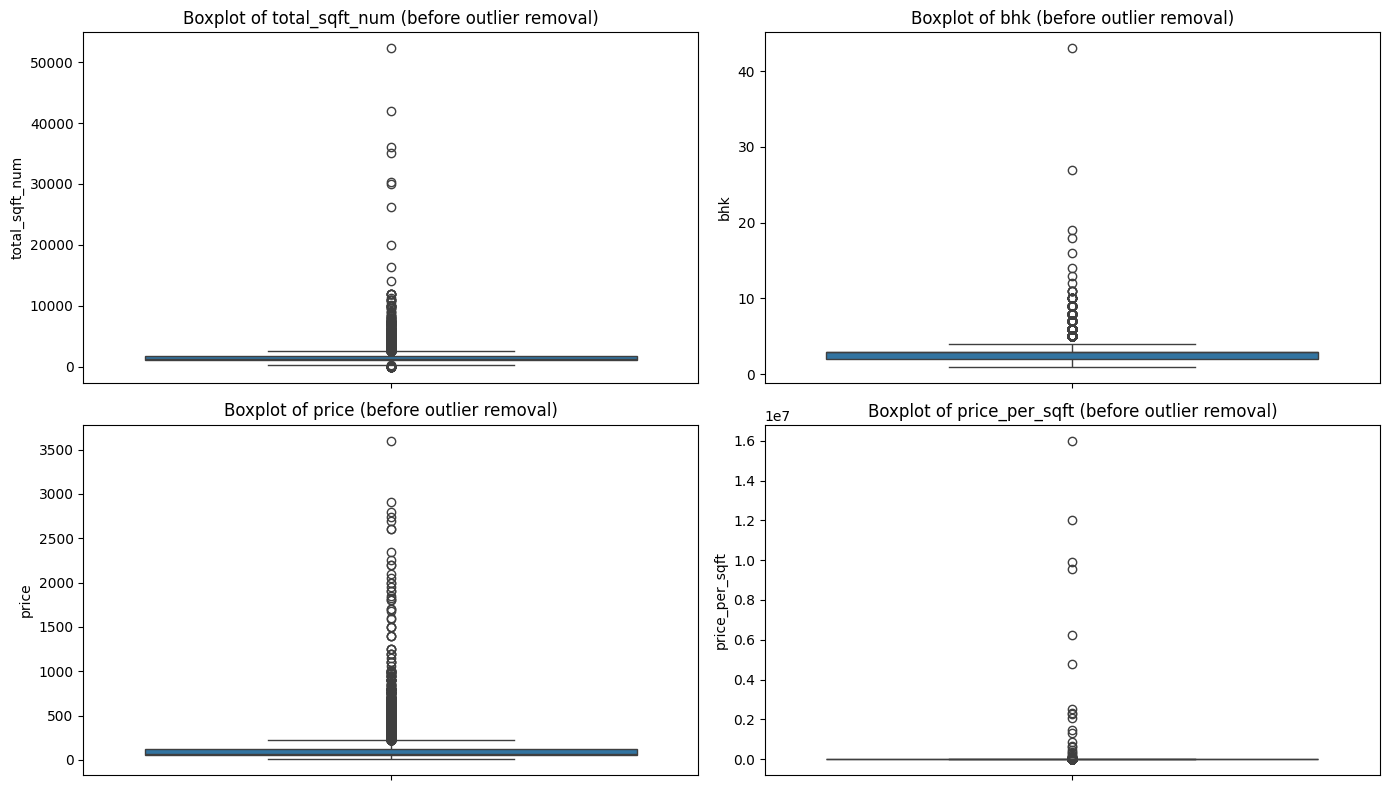

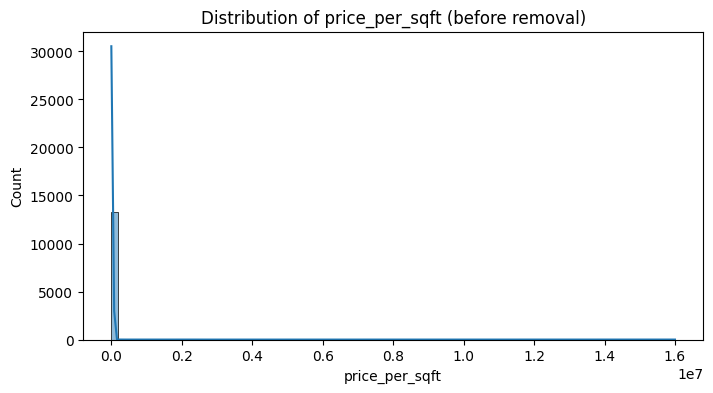

IQR bounds for price_per_sqft: -318.5958778064032 11924.490860017175
Outliers (IQR) count: 1286


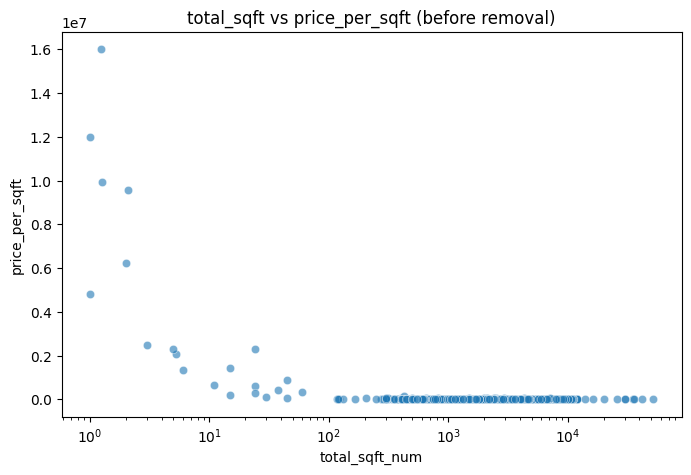

In [5]:
# 4. Outlier detection & visualization (before removal)
# Methods:
#  - IQR on price_per_sqft
#  - Z-score for numeric columns (optionally)
# boxplots for key numeric columns.
numeric_cols = ['total_sqft_num','bhk','price','price_per_sqft']
plt.figure(figsize=(14,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2,2,i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col} (before outlier removal)')
plt.tight_layout()
plt.savefig("boxplots_before_outlier_removal.png")
plt.show()

# Show distribution of price_per_sqft
plt.figure(figsize=(8,4))
sns.histplot(df['price_per_sqft'], bins=80, kde=True)
plt.title('Distribution of price_per_sqft (before removal)')
plt.savefig("hist_price_per_sqft_before.png")
plt.show()

# Detect outliers using IQR on price_per_sqft
Q1 = df['price_per_sqft'].quantile(0.25)
Q3 = df['price_per_sqft'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
print("IQR bounds for price_per_sqft:", lower_bound, upper_bound)

outliers_mask = (df['price_per_sqft'] < lower_bound) | (df['price_per_sqft'] > upper_bound)
print("Outliers (IQR) count:", outliers_mask.sum())

# Visualize outliers on scatter: total_sqft vs price_per_sqft
plt.figure(figsize=(8,5))
sns.scatterplot(x='total_sqft_num', y='price_per_sqft', data=df, alpha=0.6)
plt.title('total_sqft vs price_per_sqft (before removal)')
plt.xscale('log')  # helpful for readability
plt.savefig("scatter_before_outlier_removal.png")
plt.show()

Shape after removing IQR outliers: (12006, 12)


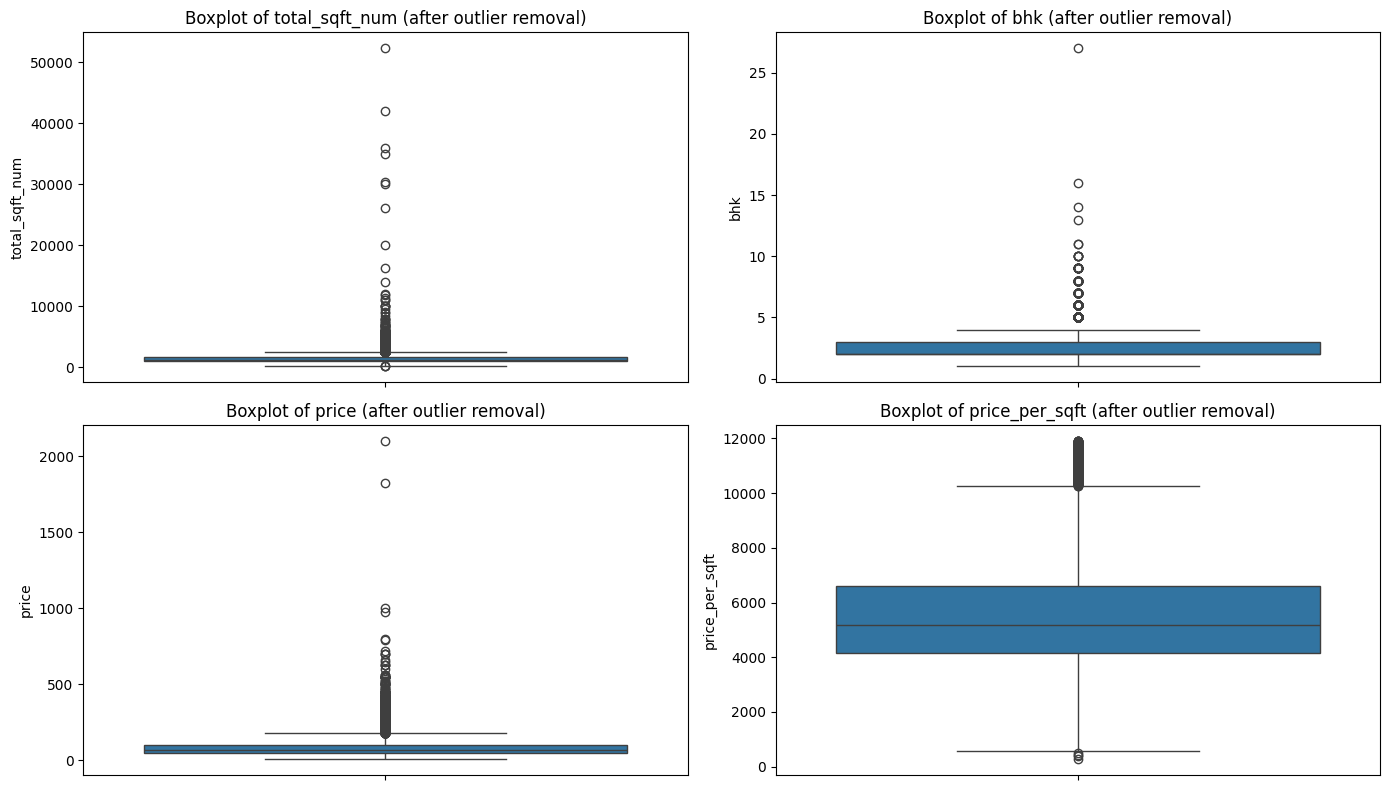

In [6]:
# 5. Remove outliers and re-plot

df_no_out = df[~outliers_mask].copy()
print("Shape after removing IQR outliers:", df_no_out.shape)

plt.figure(figsize=(14,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2,2,i)
    sns.boxplot(y=df_no_out[col])
    plt.title(f'Boxplot of {col} (after outlier removal)')
plt.tight_layout()
plt.savefig("boxplots_after_outlier_removal.png")
plt.show()

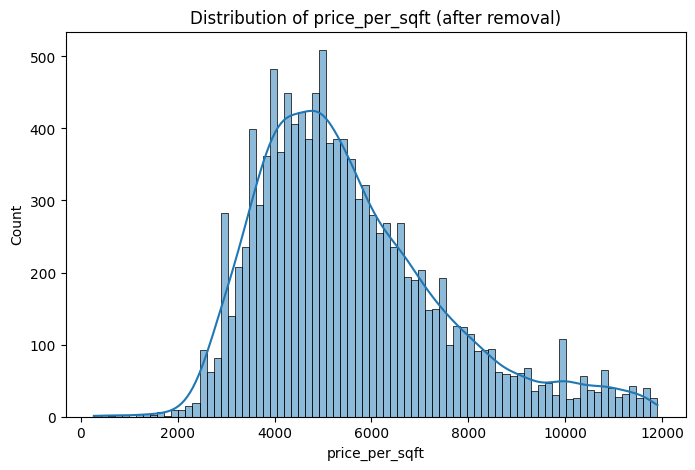

In [7]:
plt.figure(figsize=(8,5))
sns.histplot(df_no_out['price_per_sqft'], bins=80, kde=True)
plt.title('Distribution of price_per_sqft (after removal)')
plt.savefig("hist_price_per_sqft_after.png")
plt.show()

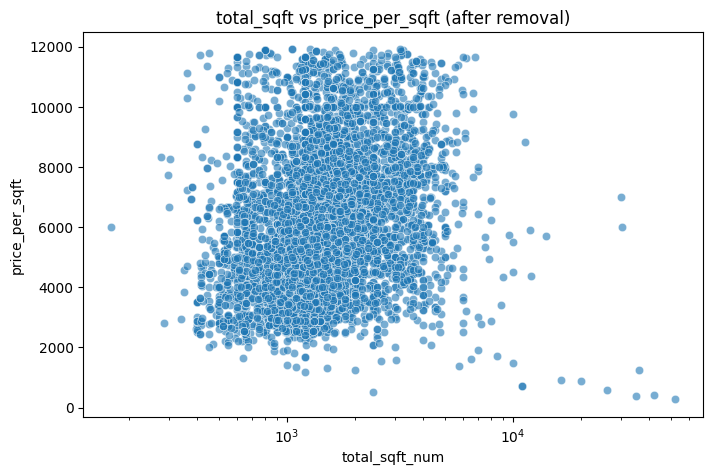

In [8]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='total_sqft_num', y='price_per_sqft', data=df_no_out, alpha=0.6)
plt.title('total_sqft vs price_per_sqft (after removal)')
plt.xscale('log')
plt.savefig("scatter_after_outlier_removal.png")
plt.show()

In [9]:
# 6. Handle missing values
#  Drop rows missing essential numeric values (we already dropped)
#  For categorical 'location', fill with 'Unknown' and group rare locations
if 'location' in df_no_out.columns:
    # Clean spaces
    df_no_out['location'] = df_no_out['location'].apply(lambda x: x.strip() if isinstance(x, str) else x)
    # Group rare locations into 'other'
    location_counts = df_no_out['location'].value_counts()
    rare_locs = location_counts[location_counts <= 10].index  # threshold = 10
    df_no_out['location_clean'] = df_no_out['location'].apply(lambda x: 'other' if x in rare_locs else x)
else:
    df_no_out['location_clean'] = 'Unknown'

# If bedrooms (bhk) still has NaN, fill with median
df_no_out['bhk'] = df_no_out['bhk'].fillna(df_no_out['bhk'].median())

# Confirm missing
print("\nMissing after handling:")
print(df_no_out.isnull().sum())


Missing after handling:
area_type            0
availability         0
location             1
size                 0
society           4494
total_sqft           0
bath                55
balcony            437
price                0
bhk                  0
total_sqft_num       0
price_per_sqft       0
location_clean       1
dtype: int64


In [10]:
# 7. Prepare features & labels
# total_sqft_num, bhk, price_per_sqft (we will not use price_per_sqft as predictor of price)
# location_clean (one-hot)
# Target for regression: price
# Target for classification: expensive vs not (price above median)
feature_cols = ['total_sqft_num', 'bhk', 'location_clean']

X = df_no_out[feature_cols].copy()
y_reg = df_no_out['price'].copy()  # price in lakhs (if original dataset is in lakhs)
# Classification target: expensive if price > median
median_price = y_reg.median()
y_clf = (y_reg > median_price).astype(int)

print("Regression sample:", y_reg.head())
print("Classification label distribution:", y_clf.value_counts())

# One-hot encode location using ColumnTransformer
categorical_features = ['location_clean']
numeric_features = ['total_sqft_num','bhk']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Create train-test split (same split for reg & clf)
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42)

# Fit preprocessor on training
preprocessor.fit(X_train)

X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

print("Feature matrix shape after preprocessing:", X_train_p.shape)

Regression sample: 0     39.07
1    120.00
2     62.00
3     95.00
4     51.00
Name: price, dtype: float64
Classification label distribution: price
0    6055
1    5951
Name: count, dtype: int64
Feature matrix shape after preprocessing: (9604, 221)


In [11]:
# 8. Train Models (Regressors)
# LinearRegression
# DecisionTreeRegressor
# GradientBoostingRegressor
# Evaluate with RMSE, MAE, R2

regressors = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42, max_depth=6),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42, n_estimators=100)
}

reg_results = {}
for name, model in regressors.items():
    model.fit(X_train_p, y_reg_train)
    preds = model.predict(X_test_p)
    rmse = np.sqrt(mean_squared_error(y_reg_test, preds))
    mae = mean_absolute_error(y_reg_test, preds)
    r2 = r2_score(y_reg_test, preds)
    reg_results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    print(f"\nRegressor: {name}")
    print(" RMSE:", rmse, " MAE:", mae, " R2:", r2)


Regressor: LinearRegression
 RMSE: 47.68559193277304  MAE: 24.28299344177602  R2: 0.4867244057934522

Regressor: DecisionTreeRegressor
 RMSE: 32.82602554242298  MAE: 20.752767228803346  R2: 0.7567723943447051

Regressor: GradientBoostingRegressor
 RMSE: 31.24776791410896  MAE: 19.839946796180374  R2: 0.7795986455534416


In [12]:
# 9. Train Models (Classifiers)
# LogisticRegression
# DecisionTreeClassifier
# GradientBoostingClassifier
# Evaluate with accuracy, error rate, precision, recall, f1

classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42, max_depth=8),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

clf_results = {}
for name, model in classifiers.items():
    model.fit(X_train_p, y_clf_train)
    preds = model.predict(X_test_p)
    acc = accuracy_score(y_clf_test, preds)
    err = 1 - acc
    prec = precision_score(y_clf_test, preds, zero_division=0)
    rec = recall_score(y_clf_test, preds, zero_division=0)
    f1 = f1_score(y_clf_test, preds, zero_division=0)
    clf_results[name] = {'Accuracy': acc, 'ErrorRate': err, 'Precision': prec, 'Recall': rec, 'F1': f1}
    print(f"\nClassifier: {name}")
    print(" Accuracy:", acc, " ErrorRate:", err, " Precision:", prec, " Recall:", rec, " F1:", f1)
    # confusion matrix
    cm = confusion_matrix(y_clf_test, preds)
    print(" Confusion matrix:\n", cm)


Classifier: LogisticRegression
 Accuracy: 0.8305578684429642  ErrorRate: 0.1694421315570358  Precision: 0.8458029197080292  Recall: 0.7957081545064377  F1: 0.8199911543564794
 Confusion matrix:
 [[1068  169]
 [ 238  927]]

Classifier: DecisionTreeClassifier
 Accuracy: 0.8368026644462948  ErrorRate: 0.1631973355537052  Precision: 0.8346320346320346  Recall: 0.8274678111587983  F1: 0.8310344827586207
 Confusion matrix:
 [[1046  191]
 [ 201  964]]

Classifier: GradientBoostingClassifier
 Accuracy: 0.8405495420482931  ErrorRate: 0.15945045795170687  Precision: 0.824212271973466  Recall: 0.8532188841201717  F1: 0.8384647827920708
 Confusion matrix:
 [[1025  212]
 [ 171  994]]



Feature names: ['total_sqft_num', 'bhk', 'location_clean_1st Phase JP Nagar', 'location_clean_2nd Phase Judicial Layout', 'location_clean_5th Phase JP Nagar', 'location_clean_6th Phase JP Nagar', 'location_clean_7th Phase JP Nagar', 'location_clean_8th Phase JP Nagar', 'location_clean_9th Phase JP Nagar', 'location_clean_AECS Layout'] ... (total 221)

Top feature importances (GradientBoostingRegressor):


,0
total_sqft_num,0.944783
bhk,0.036965
location_clean_Hebbal,0.002283
location_clean_Rajaji Nagar,0.002007
location_clean_Chikka Tirupathi,0.001401
location_clean_Frazer Town,0.001101
location_clean_Whitefield,0.000988
location_clean_Koramangala,0.000985
location_clean_Indira Nagar,0.000951
location_clean_Hebbal Kempapura,0.000950


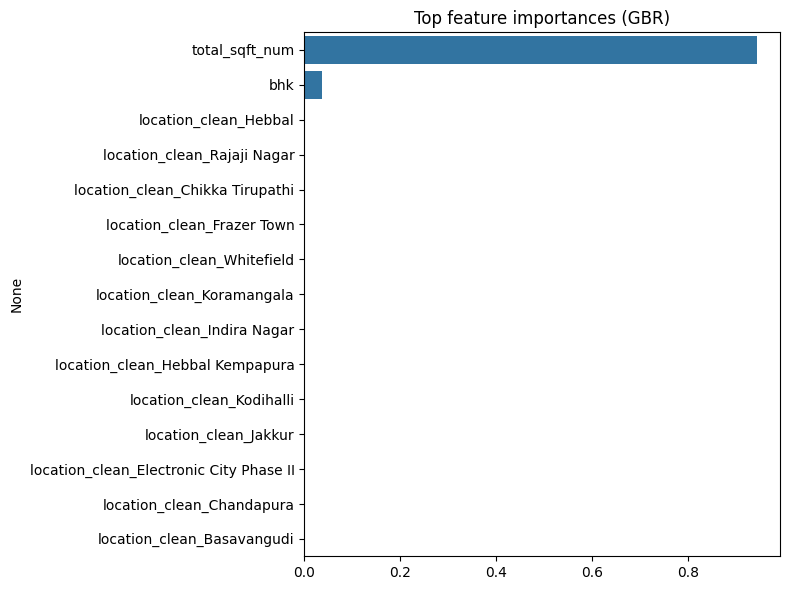

In [13]:
# 10. Feature importance for tree-based regressors & classifiers
# Show top features from GradientBoostingRegressor and DecisionTree

cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = list(cat_encoder.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + cat_feature_names

print("\nFeature names:", all_feature_names[:10], "... (total {})".format(len(all_feature_names)))

# Get feature importances from GradientBoostingRegressor
if 'GradientBoostingRegressor' in regressors:
    gbr = regressors['GradientBoostingRegressor']
    try:
        importances = gbr.feature_importances_
        fi = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
        print("\nTop feature importances (GradientBoostingRegressor):")
        display(fi.head(15))
        plt.figure(figsize=(8,6))
        sns.barplot(x=fi.head(15).values, y=fi.head(15).index)
        plt.title('Top feature importances (GBR)')
        plt.tight_layout()
        plt.savefig("feature_importances_gbr.png")
        plt.show()
    except Exception as e:
        print("Couldn't get feature importances for GBR:", e)


Regression results:


,Model,RMSE,MAE,R2
0,LinearRegression,47.685592,24.282993,0.486724
1,DecisionTreeRegressor,32.826026,20.752767,0.756772
2,GradientBoostingRegressor,31.247768,19.839947,0.779599


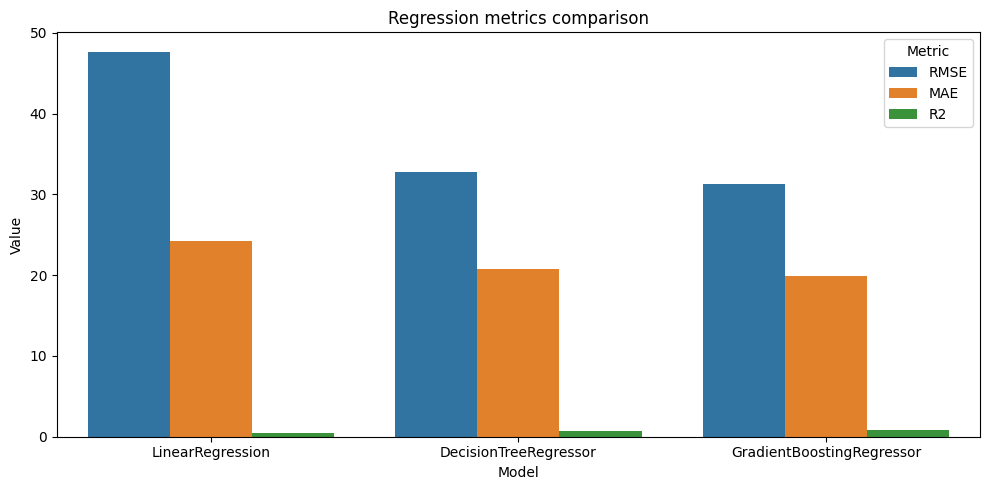


Classifier results:


,Model,Accuracy,ErrorRate,Precision,Recall,F1
0,LogisticRegression,0.830558,0.169442,0.845803,0.795708,0.819991
1,DecisionTreeClassifier,0.836803,0.163197,0.834632,0.827468,0.831034
2,GradientBoostingClassifier,0.840550,0.159450,0.824212,0.853219,0.838465


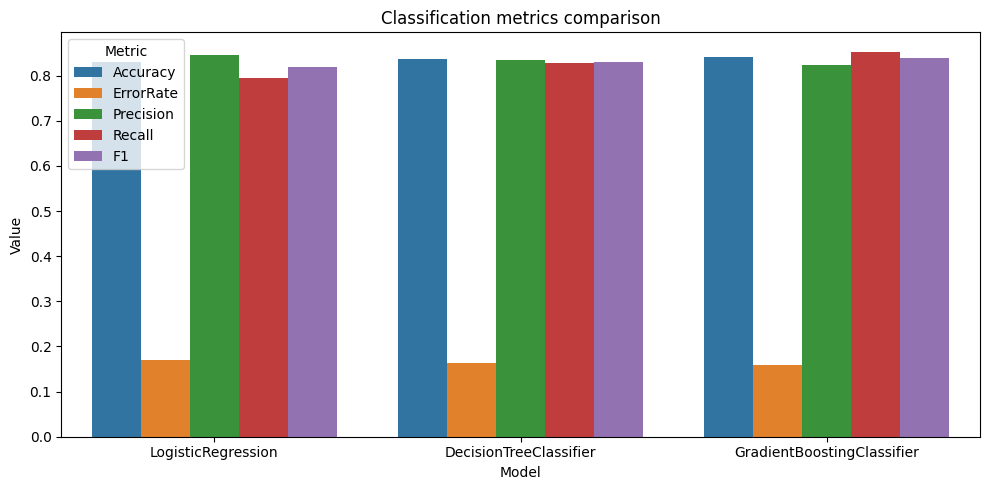

In [14]:
# 11. Compare model performance visually
# Regression comparison barplot (RMSE, MAE)
reg_df = pd.DataFrame(reg_results).T.reset_index().rename(columns={'index':'Model'})
print("\nRegression results:")
display(reg_df)
reg_df_melt = reg_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

plt.figure(figsize=(10,5))
sns.barplot(data=reg_df_melt, x='Model', y='Value', hue='Metric')
plt.title('Regression metrics comparison')
plt.tight_layout()
plt.savefig("regression_comparison.png")
plt.show()

# Classification comparison barplot
clf_df = pd.DataFrame(clf_results).T.reset_index().rename(columns={'index':'Model'})
print("\nClassifier results:")
display(clf_df)
clf_df_melt = clf_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

plt.figure(figsize=(10,5))
sns.barplot(data=clf_df_melt, x='Model', y='Value', hue='Metric')
plt.title('Classification metrics comparison')
plt.tight_layout()
plt.savefig("classification_comparison.png")
plt.show()

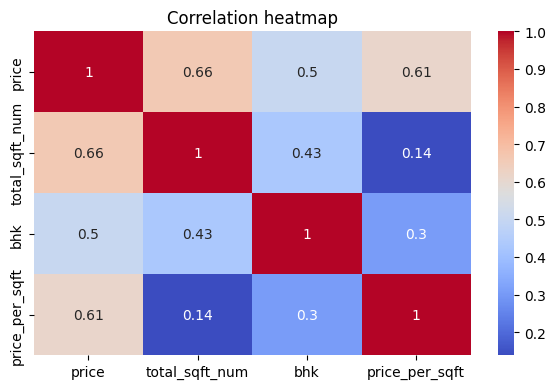

In [15]:
# 12. Correlation & heatmap (numeric features)

corr_df = df_no_out[['price','total_sqft_num','bhk','price_per_sqft']].copy()
plt.figure(figsize=(6,4))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

In [17]:
# 13. Summary: Save results to CSV for inclusion in presentation

reg_df.to_csv("regression_results.csv", index=False)
clf_df.to_csv("classification_results.csv", index=False)